# Model

In this notebook, I will test some models to determine which model performs best.  I want my final model to be interpretable so I will only be testing white box models.

- [Imports](#imports)
- [Data Prep](#dataprep)
- [Models](#models)
    - [Overview model selection](#overviewmodel)
    - [Model Selection](#modelsel)
- [Running Models](#runmodel)
    - [Random Forest](#rfc)
    - [Extra Tree Classifier](#etc)
    - [Bagging Classifier](#bag)
    - [Vote Ensemble Random Forest](#vote)
- [Final Model](#final)

# Imports  <a id=imports></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
random_state = 42

import python_code.Scripts as sc
import python_code.Reference as ref
import pickle

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,recall_score,precision_score
from treeinterpreter import treeinterpreter as ti
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

/Users/decca/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv("./data/final.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FSGRINC   3904 non-null   float64
 1   REALPROP  3904 non-null   float64
 2   FSGA      3904 non-null   float64
 3   FSSSI     3904 non-null   float64
 4   CERTHHSZ  3904 non-null   float64
 5   FSDIS     3904 non-null   float64
 6   FSSLTDE2  3904 non-null   float64
 7   FSUNEARN  3904 non-null   float64
 8   FSTOTDED  3904 non-null   float64
 9   TANF_IND  3904 non-null   float64
 10  LIQRESOR  3904 non-null   float64
 11  FSWAGES   3904 non-null   float64
 12  FSSLTDED  3904 non-null   float64
 13  FSNONCIT  3904 non-null   float64
 14  FSERNDED  3904 non-null   float64
 15  FSEARN    3904 non-null   float64
 16  FSTOTDE2  3904 non-null   float64
 17  FSSTDDE2  3904 non-null   float64
 18  FSERNDE2  3904 non-null   float64
 19  FSUSIZE   3904 non-null   float64
 20  WRK_POOR  3904 non-null   floa

# Data Prep <a id=dataprep></a>

In [4]:
X = df.drop(columns = ['CAT_ELIG'])
y = df['CAT_ELIG']

In [5]:
#baseline, NULL Model
y.value_counts(normalize=True)

1.0    0.662398
0.0    0.337602
Name: CAT_ELIG, dtype: float64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=random_state)

In [7]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [8]:
np.savetxt('./data/TrainTest/X_train.csv',X_train,delimiter=',')
np.savetxt('./data/TrainTest/y_train.csv',y_train,delimiter=',')
np.savetxt('./data/TrainTest/X_test.csv',X_test,delimiter=',')
np.savetxt('./data/TrainTest/y_test.csv',y_test,delimiter=',')

In [9]:
pca = PCA(n_components=10,random_state=42)
pca.fit(X_train)
X_train_pc = pca.transform(X_train)
X_test_pc = pca.transform(X_test)

# Models <a id=models></a>

### _Overview model selection_ <a id=overviewmodel></a>

___White box models___
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient
- Ada
- SVM
- Naive Bayes


In [10]:
models = {
    'LogReg': LogisticRegression(),
    'Decision Tree':DecisionTreeClassifier(),
    'Random Forest':RandomForestClassifier(),
    'Gradient Boost':GradientBoostingClassifier(),
    'Ada Boost':AdaBoostClassifier(),
    'SVC':SVC(),
    'Naive Bayes':GaussianNB()}

In [11]:
#adapted from Dan Brown lecture
final = pd.DataFrame(columns = ['cross_val_train','cross_val_test','test_recall','test_precision'])
idx=0
while idx < len(models.keys()):
    for name,model in models.items():
        results = {}
        results['name']=name
        name=model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        results['cross_val_train'] = np.mean(cross_val_score(model,X_train,y_train,cv=4))
        results['cross_val_test'] = np.mean(cross_val_score(model,X_test,y_test,cv=4))
        results['test_recall'] = recall_score(y_test, y_pred_test)
        results['test_precision'] = precision_score(y_test, y_pred_test)
        final = final.append(results,ignore_index=True)
        idx+=1

In [12]:
final.set_index('name')

,cross_val_train,cross_val_test,test_recall,test_precision
name,,,,
LogReg,0.884334,0.862628,0.900262,0.903821
Decision Tree,0.907760,0.913823,0.943570,0.941099
Random Forest,0.942533,0.934300,0.965879,0.955844
Gradient Boost,0.940337,0.927474,0.950131,0.961487
Ada Boost,0.922035,0.920648,0.937008,0.939474
SVC,0.884700,0.854949,0.901575,0.928378
Naive Bayes,0.767204,0.741468,0.833333,0.908441


Adding PCA to the data and comparing the scores:

In [13]:
pc_final = pd.DataFrame(columns = ['cross_val_train','cross_val_test','test_recall','test_precision'])
idx=0
while idx < len(models.keys()):
    for name,model in models.items():
        results = {}
        results['name']=name
        name=model.fit(X_train_pc, y_train)
        y_pred_train = model.predict(X_train_pc)
        y_pred_test = model.predict(X_test_pc)
        results['cross_val_train'] = np.mean(cross_val_score(model,X_train_pc,y_train,cv=4))
        results['cross_val_test'] = np.mean(cross_val_score(model,X_test_pc,y_test,cv=4))
        results['test_recall'] = recall_score(y_test, y_pred_test)
        results['test_precision'] = precision_score(y_test, y_pred_test)
        pc_final = pc_final.append(results,ignore_index=True)
        idx+=1

In [14]:
pc_final.set_index('name')

,cross_val_train,cross_val_test,test_recall,test_precision
name,,,,
LogReg,0.783675,0.763652,0.892388,0.770102
Decision Tree,0.826867,0.816553,0.892388,0.868455
Random Forest,0.883236,0.860068,0.929134,0.898477
Gradient Boost,0.877379,0.860068,0.908136,0.882653
Ada Boost,0.852855,0.848123,0.900262,0.879487
SVC,0.831991,0.834471,0.874016,0.871728
Naive Bayes,0.726940,0.713311,0.958005,0.692600


### _Model Selection_  <a id=modelsel></a>

The best performing models are Random Forest and Gradient Boost without PCA.  PCA seemed to exaggerate overfitting on all models. The Gradient Boost has the least overfitting.  Therefore, I will GridSearch over a RandomForest with Gradient Boost.  Just to make sure, I will check out the classification report for each model to verify each class is represented fairly well.

In [15]:
for name,model in models.items():
    name = model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred_test))
    print('\n')

LogisticRegression()
              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82       410
         1.0       0.90      0.90      0.90       762

    accuracy                           0.87      1172
   macro avg       0.86      0.86      0.86      1172
weighted avg       0.87      0.87      0.87      1172



DecisionTreeClassifier()
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89       410
         1.0       0.94      0.93      0.94       762

    accuracy                           0.92      1172
   macro avg       0.91      0.91      0.91      1172
weighted avg       0.92      0.92      0.92      1172



RandomForestClassifier()
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93       410
         1.0       0.96      0.96      0.96       762

    accuracy                           0.95      1172
   macro avg       0.94      0.94      0.94      1172

What we see is that Random Forest and Gradient Boosting represent the classes most fairly among all other models.  Since there is an inbalance of classes for the target variable (2007 data had some people who qualified and some who didn't, whereas everyone qualified for SNAP in 2017) I would expect boosting would be essential to this model.

# Running models  <a id=runmodel></a>

### _Random forest_  <a id=rfc></a>

I will start with Random Forest for interpretability.

In [16]:
rf = RandomForestClassifier()
params={'max_depth':[None,3,4],
       'max_features':[None,'auto'],
       'n_estimators':[75,100,125]}
rf_gs = GridSearchCV(rf,param_grid=params)
rf_gs.fit(X_train,y_train)
print(rf_gs.best_score_)
rf_gs.best_params_

0.9454600853138331


{'max_depth': None, 'max_features': 'auto', 'n_estimators': 75}

The result shows the defaults were the best model.

In [17]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

Following code adapted from [Demystify the random forest](https://www.kaggle.com/akashram/demystify-the-random-forest) and [Visualizing Dot-Whisker Regression Coefficients in Python](https://zhiyzuo.github.io/Python-Plot-Regression-Coefficient/)

In [18]:
instances = X_test[[735]]
instances

array([[-1.25472977, -0.03517855, -0.1335093 , -0.42833737,  1.02614408,
        -0.51403261, -0.87253073, -0.91848291,  0.39411313, -0.36488324,
        -0.24501332, -0.55893964,  1.0459183 ,  1.78070948, -0.59758589,
        -0.59800159, -1.28640995, -1.59315573, -0.56404251,  1.02614408,
        -0.76825854, -0.24309398, -0.34230342, -0.51614194, -0.40909055,
         1.00652396, -1.49056789, -0.8826584 , -0.88061189, -0.59885312,
        -0.02833014, -0.35352552]])

In [19]:
ft_list = []
prediction, bias, contributions = ti.predict(rf, instances)
print( "Prediction", prediction)
print( "Bias (trainset prior)", bias)
print ("Feature contributions:")
for c, feature in zip(contributions[0], 
                             X.columns):
    ft_list.append((feature, np.round(c, 2)))
    print (feature, c)
    
labels, values = zip(*ft_list)

Prediction [[0.63 0.37]]
Bias (trainset prior) [[0.33179356 0.66820644]]
Feature contributions:
FSGRINC [ 0.00101856 -0.00101856]
REALPROP [0. 0.]
FSGA [ 0.00418878 -0.00418878]
FSSSI [ 0.01309253 -0.01309253]
CERTHHSZ [ 0.0262957 -0.0262957]
FSDIS [ 0.00263219 -0.00263219]
FSSLTDE2 [-0.00625606  0.00625606]
FSUNEARN [ 0.0326217 -0.0326217]
FSTOTDED [-0.05840197  0.05840197]
TANF_IND [ 0.01607689 -0.01607689]
LIQRESOR [-0.02204246  0.02204246]
FSWAGES [-0.00399179  0.00399179]
FSSLTDED [ 0.11105917 -0.11105917]
FSNONCIT [ 0.00639098 -0.00639098]
FSERNDED [-0.00217986  0.00217986]
FSEARN [-0.012072  0.012072]
FSTOTDE2 [ 0.01052122 -0.01052122]
FSSTDDE2 [ 0.03648276 -0.03648276]
FSERNDE2 [-0.00600816  0.00600816]
FSUSIZE [ 0.01647 -0.01647]
WRK_POOR [-0.00850344  0.00850344]
FSASSET [-0.0245858  0.0245858]
FSTANF [ 0.02930317 -0.02930317]
HWGT [ 0.04318954 -0.04318954]
FSNELDER [ 0.00107899 -0.00107899]
SHELDED [ 0.1017754 -0.1017754]
TPOV [ 0.00784386 -0.00784386]
FSNETINC [-0.00079596 

In [27]:
df1 = pd.DataFrame(ft_list,columns=['feature','array'])
df2 = pd.DataFrame(df1["array"].to_list(), columns=['pred_0', 'pred_1'])
coef_df = pd.concat([df1,df2],axis=1).drop(columns=['array'])
coef_df.to_csv('./data/2018_indicators/coef.csv',index=None)

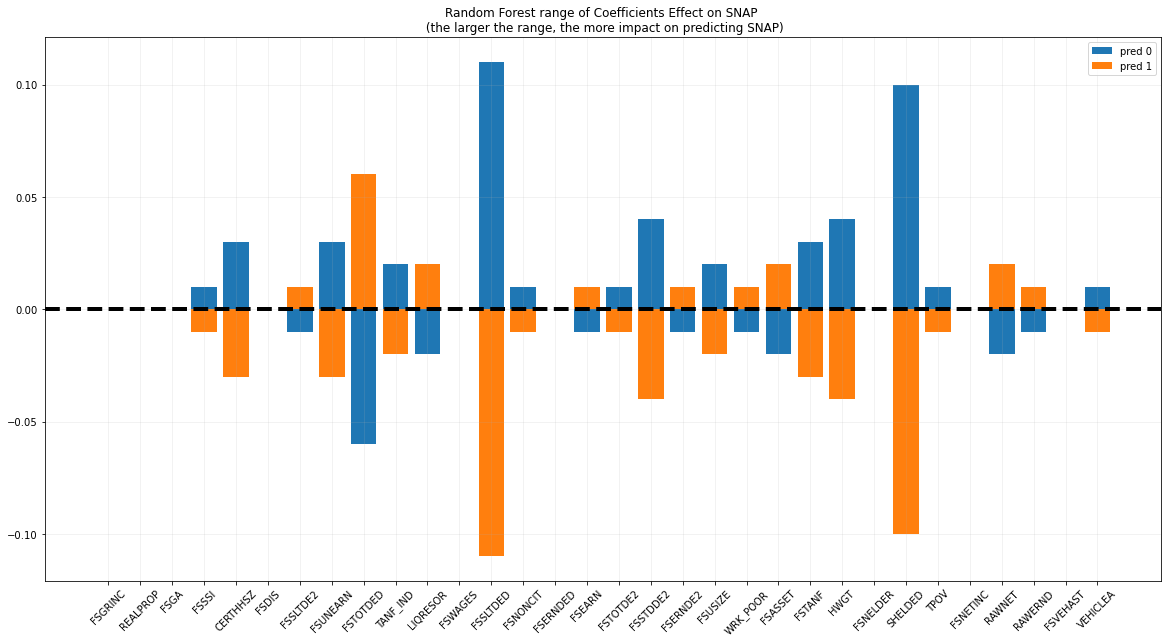

In [21]:
fig, ax = plt.subplots(figsize=(20,10))
plt.title('Random Forest range of Coefficients Effect on SNAP \n (the larger the range, the more impact on predicting SNAP)')
plt.grid(zorder=0,alpha = 0.2)
xs = np.arange(len(labels))
ax.bar(xs,coef_df['pred_0'], label = 'pred 0')
ax.bar(xs,coef_df['pred_1'],label = 'pred 1')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.set_xticks(coef_df.index)
ax.set_xticklabels(coef_df['feature'],rotation = 45)
plt.legend()
plt.savefig('./images/rf_corr.png');

### _Extra Tree Classifier_ <a id=etc></a>

I will compare a gridsearch Extra Tree classifier to see if it should be added to the ensemble. 

In [22]:
et = ExtraTreeClassifier()
params={'max_depth':[None,3,4],
       'max_features':[None,'auto'],
       'max_leaf_nodes':[5,10]}
et_gs = GridSearchCV(et,param_grid=params)
et_gs.fit(X_train,y_train)
print(et_gs.best_score_)
et_gs.best_params_

0.8275736451239194


{'max_depth': None, 'max_features': None, 'max_leaf_nodes': 10}

It seems the random with replacement that isn't offered in the Extra Tree Classifier is important to predicting SNAP eligibility.  Further magnifying the more than slight class imbalance of the target column.  Therefore, Extra Tree Classifier will not be used in the Ensemble.

### _Bagging Classifier_  <a id=bag></a>

Since there is slight overfitting due to less variability in my target class, I will test a bagging classifier to see if I should place it in my Vote Ensemble.

In [23]:
bag = BaggingClassifier()
bag.fit(X_train,y_train)
y_pred_train = bag.predict(X_train)
y_pred_test = bag.predict(X_test)
print(f'cross_val_train = {np.mean(cross_val_score(model,X_train_pc,y_train,cv=4))}')
print(f'cross_val_test = {np.mean(cross_val_score(model,X_test_pc,y_test,cv=4))}')
print(f'test_recall = {recall_score(y_test, y_pred_test)}')
print(f'test_precision = {precision_score(y_test, y_pred_test)}')

cross_val_train = 0.7269399707174231
cross_val_test = 0.7133105802047782
test_recall = 0.9501312335958005
test_precision = 0.9551451187335093


The cross val score is actually pretty low for both train and test, but it doesn't appear to be overfitting.  The test recall and precision is actually very high, meaning it is predicting positives very acurately.  I will therefore add it to my vote ensemble.  Because predicting positive (ie. those that are projected to be on SNAP) is more beneficial in targeting groups that are at risk.  

### _Vote Ensemble Random Forest_  <a id=vote></a>

Now I am moving into the black box models by gridsearching through a Gradient Boosting and Bagging Classifier Vote Ensemble. Which was run in another [notebook](http://localhost:8888/lab/tree/data/TrainTest/VoteEnsemble.ipynb).  I also have the same notebook as a backup python script in case the Gridsearch was not able to complete on my local machine I could run the python script in AWS.  The results of that script are as follows:
```python
0.9509512425417362
{'bag__n_estimators': 10,
 'gb__max_depth': 10,
 'gb__subsample': 0.8,
 'rf__bootstrap': False,
 'rf__max_depth': None,
 'rf__n_estimators': 1000}
```

# Final Model  <a id=final></a>

In [24]:
vote = VotingClassifier([
    ('rf',RandomForestClassifier(bootstrap=False,n_estimators=1000)),
    ('gb',GradientBoostingClassifier(max_depth=10,subsample=0.8)),
    ('bag',BaggingClassifier(n_estimators = 10))
])

In [25]:
vote.fit(X_train,y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     n_estimators=1000)),
                             ('gb',
                              GradientBoostingClassifier(max_depth=10,
                                                         subsample=0.8)),
                             ('bag', BaggingClassifier())])

In [26]:
filename = 'final_model.sav'
pickle.dump(vote, open(filename, 'wb'))